In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import numpy
from scipy.special import gamma
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import random
import math
from numpy import abs, zeros, log10, where, arctanh, tanh
from numpy.random import uniform, standard_cauchy
from sklearn.model_selection import train_test_split
def Levy(d):
    beta = 1.5
    sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) / (gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.randn(d) * sigma
    v = np.random.randn(d)
    step = u / np.abs(v) ** (1 / beta)
    return step

def _mutation__(current_pos, new_pos,dim,crossover_ratio,lb,ub):
    pos_new = numpy.where(numpy.random.uniform(0, 1, dim) < crossover_ratio, current_pos, new_pos)
    return pos_new


def hill_climbing(position, fobj, lb, ub, max_iterations=10, step_size=0.01):
    best_position = position.copy()
    best_score = fobj(*best_position)
    
    for _ in range(max_iterations):
        # Generate a small random perturbation
        perturbation = (np.random.rand(len(position)) * 2 - 1) * step_size
        new_position = np.clip(best_position + perturbation, lb, ub)
        
        # Evaluate the new position
        new_score = fobj(*new_position)
        
        # Update if the new position is better
        if new_score < best_score:
            best_position = new_position
            best_score = new_score
        else:
            # If no improvement, reduce step size
            step_size *= 0.45
    
    return best_position, best_score
X  = pd.read_csv('miRNA-Combine-Dataset_DEGs_Zscore.csv')
y  = pd.read_csv('label.csv')
print("miRNA Elseiver shapes:", X.shape, y.shape)
miRNA_X_train, miRNA_X_test, miRNA_y_train, miRNA_y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
# Normalize the data
scaler_miRNA = StandardScaler()
X_miRNA_train_normalized = scaler_miRNA.fit_transform(miRNA_X_train)
X_miRNA_test_normalized = scaler_miRNA.transform(miRNA_X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(miRNA_y_train.values.ravel())
y_test_encoded = label_encoder.transform(miRNA_y_test.values.ravel())



class miRNADataset(Dataset):
    def __init__(self, mirna_data, labels):
        self.mirna_data = torch.FloatTensor(mirna_data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.mirna_data[idx], self.labels[idx]

class FeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FeatureExtractor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

class miRNANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(miRNANN, self).__init__()
        self.mirna_extractor = FeatureExtractor(input_size, hidden_size)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 8, num_classes)
        )

    def forward(self, mirna):
        mirna_features = self.mirna_extractor(mirna)
        output = self.classifier(mirna_features)
        return output

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50):
    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        for mirna, labels in train_loader:
            mirna, labels = mirna.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(mirna)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for mirna, labels in test_loader:
                mirna, labels = mirna.to(device), labels.to(device)
                outputs = model(mirna)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        accuracy = correct / total

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    return best_val_loss, accuracy

def objective_function(hidden_size, learning_rate, batch_size):
    set_global_seed(42)  # Reset seed for each evaluation
    
    hidden_size = int(hidden_size)
    batch_size = int(batch_size)
    
    model = miRNANN(miRNA_X_train.shape[1], hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda x: np.random.seed(42))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda x: np.random.seed(42))

    val_loss, accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device)
    
    return -accuracy  # We want to maximize accuracy, so we return negative accuracy

# Set a global random seed
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed (you can choose any integer)
set_global_seed(42)

def HCALA(fobj, dim, lb, ub, Max_iter):
    SearchAgents_no = 30

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    
    # s = solution()
   
    Position  = np.zeros(dim)  # Best-so-far Solution, representing the Sun
    Score = float('inf')  # Best-so-far score
    Convergence_curve = []
    Positions = numpy.zeros((SearchAgents_no, dim))
    fitness = np.zeros(SearchAgents_no)
    vec_flag = [1, -1]

    
    for i in range(dim):
        Positions[:, i] = numpy.random.uniform(0, 1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]
    # Controlling parameters
 
    # Evaluation
    for i in range(SearchAgents_no):
        fitness[i] = fobj(*Positions[i])
        if fitness[i] < Score:
            Position = Positions[i].copy()
            Score = fitness[i]
 
    #t = 0
    # print('HCALA is optimizing 0.45 StepSize' + function_name + '"')
    # timerStart = time.time()
    # s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    #while t < Tmax:  # Termination condition
    for Iter in range(0, Max_iter):
        RB = np.random.randn(SearchAgents_no, dim)
        F = vec_flag[np.floor(2 * np.random.rand()).astype(int)]
        theta = 2 * np.arctan(1 - Iter / Max_iter)        
        Xnew = np.zeros_like(Positions)

        for i in range(SearchAgents_no):
            E = 2 * np.log(1 / np.random.rand()) * theta
            if E > 1:
                if np.random.rand() < 0.3:
                    r1 = 2 * np.random.rand(dim) - 1
                    Xnew[i] = Position + F * RB[i] * (r1 * (Position - Positions[i]) + (1 - r1) * (Positions[i] - Positions[np.random.randint(SearchAgents_no)]))
                else:
                    r2 = np.random.rand() * (1 + np.sin(0.5 * Iter))
                    Xnew[i] = Positions[i] + F * r2 * (Position - Positions[np.random.randint(SearchAgents_no)])
            else:
                if np.random.rand() < 0.5:
                    radius = np.sqrt(np.sum((Position - Positions[i]) ** 2))
                    r3 = np.random.rand()
                    spiral = radius * (np.sin(2 * np.pi * r3) + np.cos(2 * np.pi * r3))
                    Xnew[i] = Position + F * Positions[i] * spiral * np.random.rand()
                else:
                    G = 2 * (np.sign(np.random.rand() - 0.5)) * (1 - Iter / Max_iter)
                    Xnew[i] = Position + F * G * Levy(dim) * (Position - Positions[i])

        for i in range(SearchAgents_no):
            if np.random.rand() < np.random.rand():
                for j in range(dim):
                    if Xnew[i,j] > ub[j]:
                        Xnew[i,j] = lb[j] + np.random.rand() * (ub[j] - lb[j])
                    elif Xnew[i,j] < lb[j]:
                        Xnew[i,j] = lb[j] + np.random.rand() * (ub[j] - lb[j])
            else:
                Xnew[i] = np.clip(Xnew[i], lb, ub)
            # Xnew[i] = np.clip(Xnew[i], lb, ub)
            # Xnew[i] = _mutation__(Positions[i, :],Xnew[i],dim,0.2,lb,ub)
            newPopfit = fobj(*Xnew[i])
            if newPopfit < fitness[i]:
                Positions[i, :] = Xnew[i].copy()
                fitness[i] = newPopfit
            if fitness[i] < Score:
                Position = Positions[i, :].copy()
                Score = fitness[i]    


        # Apply local search to the best solution
        if Iter % 10 == 0:  # Apply local search every 10 iterations
            Position, Score = hill_climbing(Position, fobj, lb, ub)
        
        Convergence_curve.append(Score) 
            
  
            
        # convergence_curve[l] = gBestScore
        print("Current Iteration :  ", Iter)

    return Position, -Score

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Prepare datasets
    train_dataset = miRNADataset(X_miRNA_train_normalized, y_train_encoded)
    test_dataset = miRNADataset(X_miRNA_test_normalized, y_test_encoded)

    num_classes = len(np.unique(y_train_encoded))

    dim = 3
    lb = [64, 0.0001, 16]
    ub = [512, 0.01, 128]

    # Run GWO
    best_params, best_accuracy = HCALA(objective_function, dim, lb, ub, Max_iter=100) #SMAPSO
    # best_params, best_accuracy = GWO(objective_function, lb, ub, dim, 30, Max_iter=100)
    print("Best Hyperparameters:")
    print(f"Hidden Size: {int(best_params[0])}")
    print(f"Learning Rate: {best_params[1]:.6f}")
    print(f"Batch Size: {int(best_params[2])}")
    print(f"Best Accuracy: {best_accuracy:.4f}")

    # Train final model with best hyperparameters
    set_global_seed(42)  # Reset seed for final training
    final_model = miRNANN(miRNA_X_train.shape[1], int(best_params[0]), num_classes).to(device)
    final_criterion = nn.CrossEntropyLoss()
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params[1])
    final_train_loader = DataLoader(train_dataset, batch_size=int(best_params[2]), shuffle=True, worker_init_fn=lambda x: np.random.seed(42))
    final_test_loader = DataLoader(test_dataset, batch_size=int(best_params[2]), shuffle=False, worker_init_fn=lambda x: np.random.seed(42))

    # Train and evaluate final model
    train_and_evaluate(final_model, final_train_loader, final_test_loader, final_criterion, final_optimizer, device, num_epochs=100)

    # Final evaluation
    final_model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for mirna, labels in final_test_loader:
            mirna, labels = mirna.to(device), labels.to(device)
            outputs = final_model(mirna)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='weighted')

    print("\nFinal Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


miRNA Elseiver shapes: (231, 208) (231, 1)
Current Iteration :   0
Current Iteration :   1
Current Iteration :   2
Current Iteration :   3
Current Iteration :   4
Current Iteration :   5
Current Iteration :   6
Current Iteration :   7
Current Iteration :   8
Current Iteration :   9
Current Iteration :   10
Current Iteration :   11
Current Iteration :   12
Current Iteration :   13
Current Iteration :   14
Current Iteration :   15
Current Iteration :   16
Current Iteration :   17
Current Iteration :   18
Current Iteration :   19
Current Iteration :   20
Current Iteration :   21
Current Iteration :   22
Current Iteration :   23
Current Iteration :   24
Current Iteration :   25
Current Iteration :   26
Current Iteration :   27
Current Iteration :   28
Current Iteration :   29
Current Iteration :   30
Current Iteration :   31
Current Iteration :   32
Current Iteration :   33
Current Iteration :   34
Current Iteration :   35
Current Iteration :   36
Current Iteration :   37
Current Iteration


Top 10 Most Important Features:
hsa.miR.190b: 0.0404
hsa.miR.429: 0.0404
hsa.miR.505.3p: 0.0404
hsa.miR.3614.5p: 0.0404
hsa.miR.935: 0.0426
hsa.miR.887.3p: 0.0426
hsa.miR.183.5p: 0.0447
hsa.miR.134.5p: 0.0468
hsa.miR.93.5p: 0.0468
hsa.miR.135b.5p: 0.0532


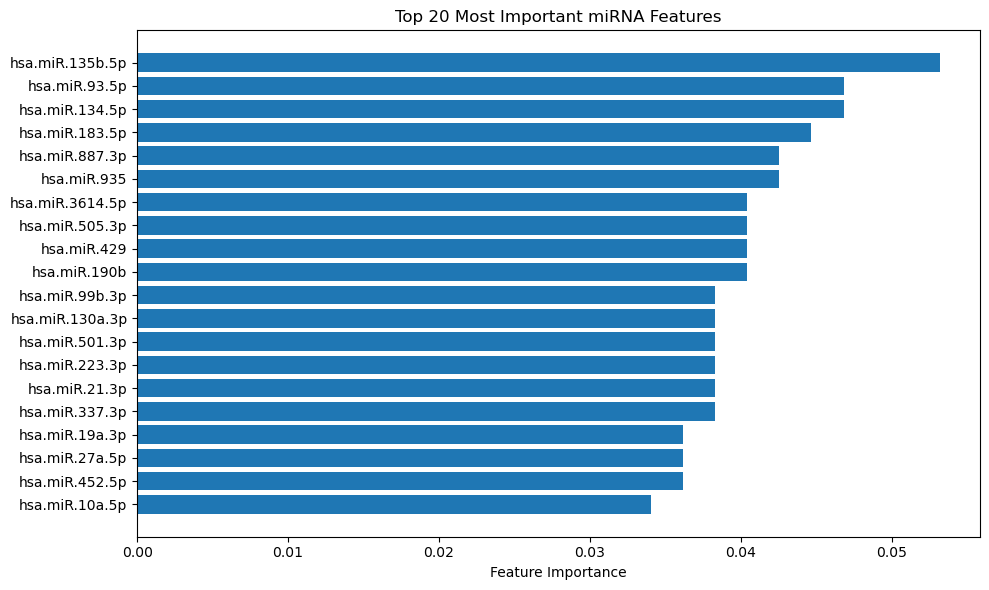

In [9]:
# FEature Importance 
import numpy as np
from sklearn.metrics import accuracy_score

def calculate_feature_importance(model, X, y, n_repeats=10):
    model.eval()
    X = torch.FloatTensor(X).to(device)
    y = torch.LongTensor(y).to(device)
    
    baseline_preds = model(X).argmax(dim=1).cpu().numpy()
    baseline_accuracy = accuracy_score(y.cpu().numpy(), baseline_preds)
    
    feature_importance = np.zeros(X.shape[1])
    
    for feature in range(X.shape[1]):
        feature_importance_scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, feature] = X_permuted[:, feature][torch.randperm(X.shape[0])]
            
            permuted_preds = model(X_permuted).argmax(dim=1).cpu().numpy()
            permuted_accuracy = accuracy_score(y.cpu().numpy(), permuted_preds)
            
            importance = baseline_accuracy - permuted_accuracy
            feature_importance_scores.append(importance)
        
        feature_importance[feature] = np.mean(feature_importance_scores)
    
    return feature_importance

# Calculate feature importance
feature_importance = calculate_feature_importance(final_model, X_miRNA_test_normalized, y_test_encoded)

# Sort features by importance
feature_names = miRNA_X_test.columns
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
for feature, importance in zip(sorted_features[-10:], sorted_importance[-10:]):
    print(f"{feature}: {importance:.4f}")

# Optionally, you can visualize the feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance[-20:])), sorted_importance[-20:])
plt.yticks(range(len(sorted_features[-20:])), sorted_features[-20:])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important miRNA Features')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

   BasalLike       1.00      0.88      0.93         8
 Controldata       1.00      1.00      1.00         8
HER2Enriched       1.00      1.00      1.00         5
    LuminalA       0.94      0.94      0.94        18
    LuminalB       0.89      1.00      0.94         8

    accuracy                           0.96        47
   macro avg       0.97      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47



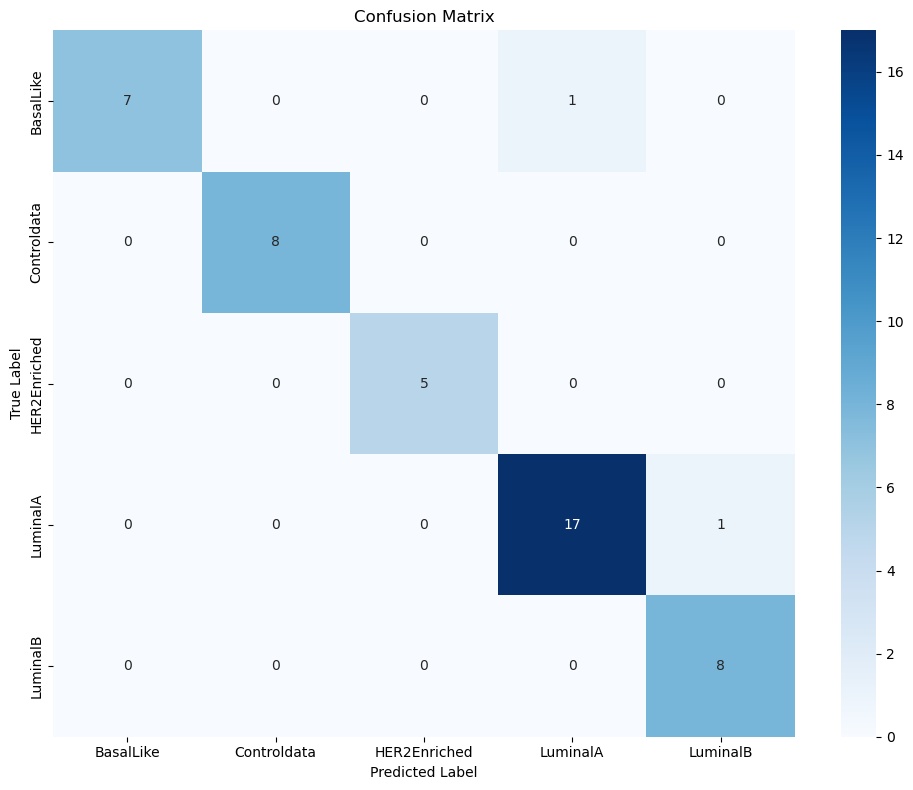

In [11]:
# Classification report and confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Assuming you have already run your model and have predictions
# If not, you need to get predictions first
final_model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for mirna, labels in final_test_loader:
        mirna, labels = mirna.to(device), labels.to(device)
        outputs = final_model(mirna)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays if they aren't already
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Get class names
class_names = label_encoder.classes_

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)